In [1]:
import numpy as np
from tqdm.autonotebook import tqdm, trange
import pandas as pd
import sys
sys.path.append('../utilities')

import evaluation
import load_data
import utils
import models_torch

C:\Users\Lyle\AppData\Local\Temp\ipykernel_38940\3717577850.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Here are some settings to make sure the notebook runs. We need to run train these for a little longer even just to check if the notebook works otherwise rejection sampling may get stuck:

In [2]:
#def_model_params is a list of: [batch_size, G_LR, D_LR, A_LR, noise_dim, epochs, n_hidden, layer_size]
def_model_params = [256, 3e-4, 3e-4, 3e-4, 8, 250, 1, 400] 
numinst = 1 #Number of instantiations to test
numgen = 5000 #Number of samples to generate
numanim = 1 #Number of intermediate steps to animate/score
scaling = True #Scale or not
scorebars = True #Print progress bars for scoring functions

Here are the settings from our actual experiments:

In [3]:
# def_model_params = [256, 3e-4, 3e-4, 3e-4, 8, 10000, 1, 400] 
# numinst = 6 #Number of instantiations to test
# numgen = 5000 #Number of samples to generate
# numanim = 1 #Number of intermediate steps to animate/score
# scaling = True #Scale or not
# scorebars = True #Print progress bars for scoring functions

100%|██████████| 4882/4882 [02:03<00:00, 39.39it/s, L_D_real=0.6813, L_D_fake=0.6997, L_G_D=0.6946, L_A_neg=0.6762, L_A_fake=0.6629, L_G_A=0.2674, L_div=10.9989]


Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.44s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.43s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.45s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.43s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.45s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.49s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.47s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.46s/it]


Calculating DPP Diversity


<Figure size 640x480 with 0 Axes>

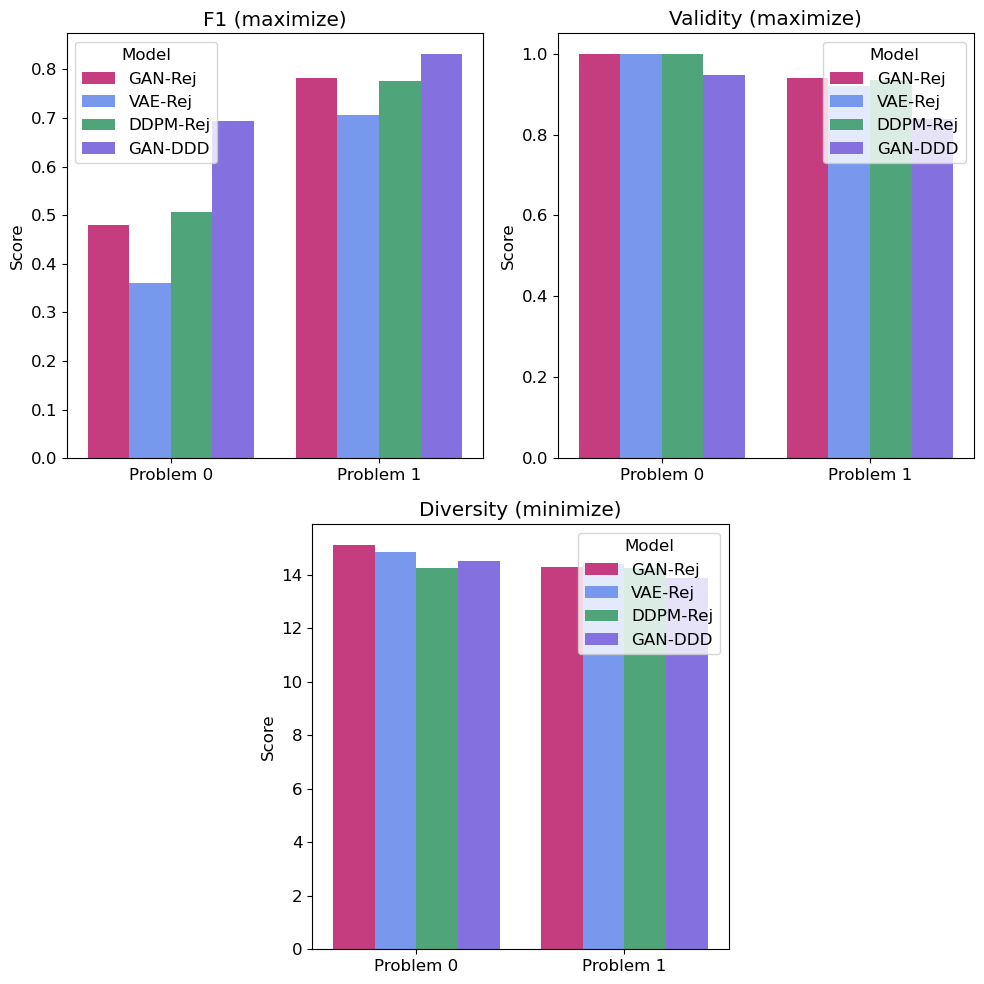

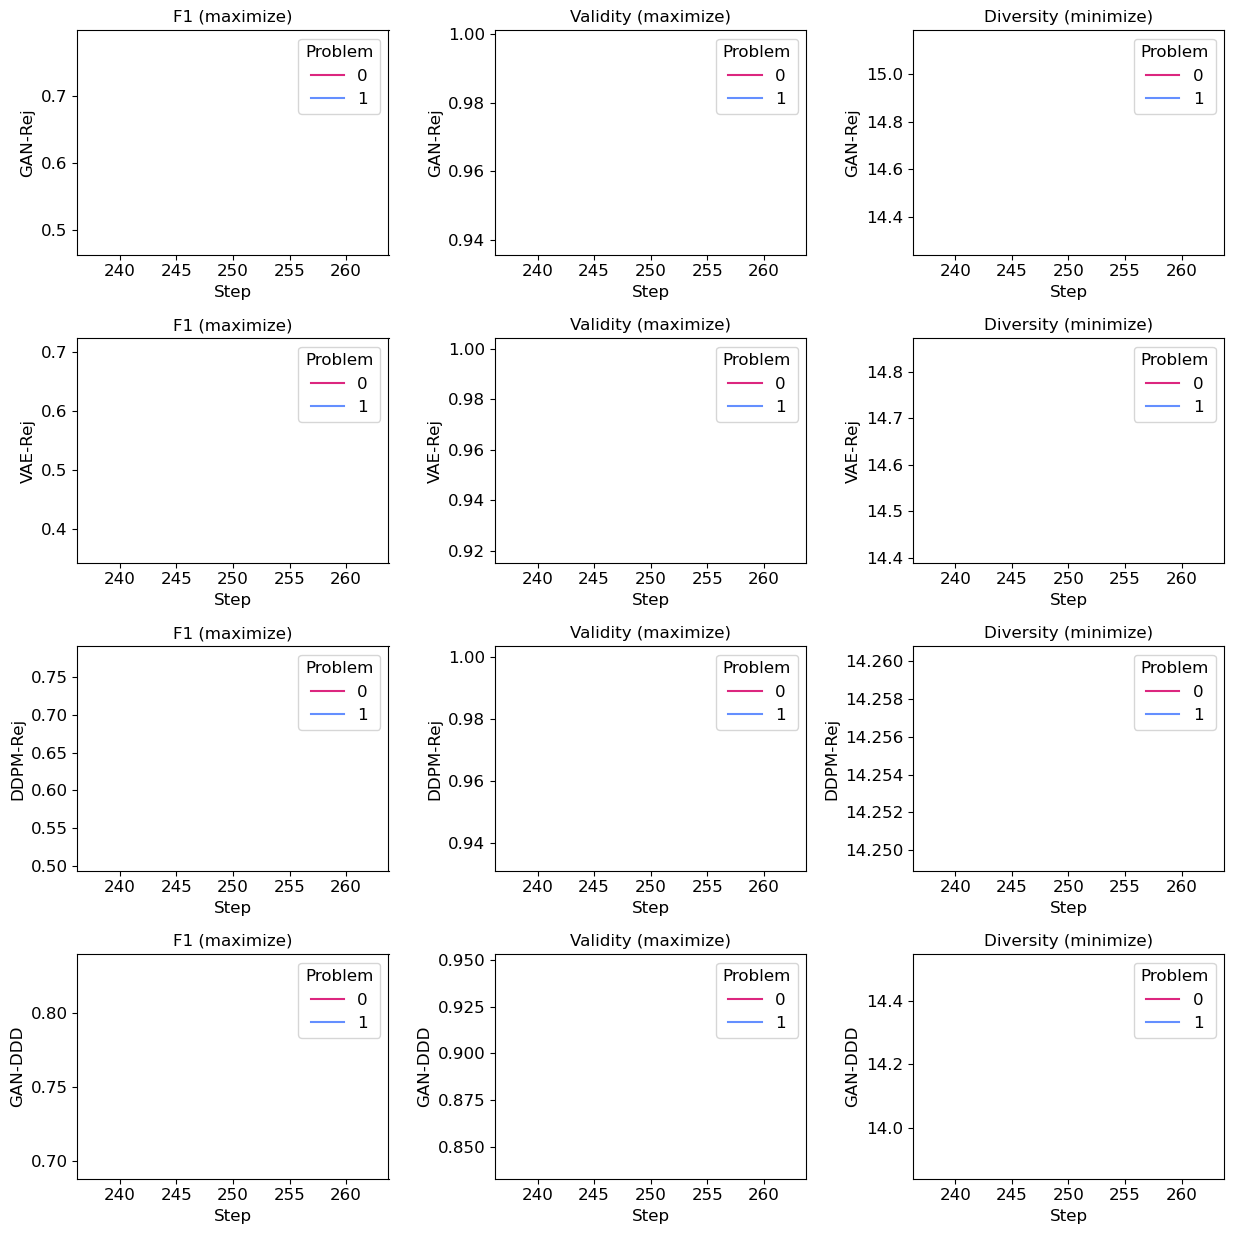

,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
F1,0.478974,0.360042,0.507199,0.694836
Validity,0.998200,1.000000,1.000000,0.947600
Diversity,15.137901,14.849880,14.249449,14.513449


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
F1,0.478974,0.360042,0.507199,0.694836
Validity,0.998200,1.000000,1.000000,0.947600
Diversity,15.137901,14.849880,14.249449,14.513449


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
F1,0.478974,0.360042,0.507199,0.694836
Validity,0.998200,1.000000,1.000000,0.947600
Diversity,15.137901,14.849880,14.249449,14.513449


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
F1,0.782694,0.705290,0.777006,0.832675
Validity,0.938600,0.919200,0.934200,0.838200
Diversity,14.286976,14.411099,14.260247,13.872707


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
F1,0.782694,0.705290,0.777006,0.832675
Validity,0.938600,0.919200,0.934200,0.838200
Diversity,14.286976,14.411099,14.260247,13.872707


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
F1,0.782694,0.705290,0.777006,0.832675
Validity,0.938600,0.919200,0.934200,0.838200
Diversity,14.286976,14.411099,14.260247,13.872707


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
Problem 1,0.478974,0.360042,0.507199,0.694836
Problem 2,0.782694,0.705290,0.777006,0.832675


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
Problem 1,0.478974,0.360042,0.507199,0.694836
Problem 2,0.782694,0.705290,0.777006,0.832675


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
Problem 1,0.478974,0.360042,0.507199,0.694836
Problem 2,0.782694,0.705290,0.777006,0.832675


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
Problem 1,0.998200,1.000000,1.000000,0.947600
Problem 2,0.938600,0.919200,0.934200,0.838200


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
Problem 1,0.998200,1.000000,1.000000,0.947600
Problem 2,0.938600,0.919200,0.934200,0.838200


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
Problem 1,0.998200,1.000000,1.000000,0.947600
Problem 2,0.938600,0.919200,0.934200,0.838200


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
Problem 1,15.137901,14.849880,14.249449,14.513449
Problem 2,14.286976,14.411099,14.260247,13.872707


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
Problem 1,15.137901,14.849880,14.249449,14.513449
Problem 2,14.286976,14.411099,14.260247,13.872707


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
Problem 1,15.137901,14.849880,14.249449,14.513449
Problem 2,14.286976,14.411099,14.260247,13.872707


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
F1,1.500000,3.000000,1.500000,0.000000
Validity,1.000000,1.500000,0.500000,3.000000
Diversity,2.500000,2.500000,0.500000,0.500000


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
F1,0.63083±0.15186,0.53267±0.17262,0.64210±0.13490,0.76376±0.06892
Validity,0.96840±0.02980,0.95960±0.04040,0.96710±0.03290,0.89290±0.05470
Diversity,14.71244±0.42546,14.63049±0.21939,14.25485±0.00540,14.19308±0.32037


,GAN-Rej,VAE-Rej,DDPM-Rej,GAN-DDD
F1,0.630834,0.532666,0.642102,0.763756
Validity,0.968400,0.959600,0.967100,0.892900
Diversity,14.712439,14.630490,14.254848,14.193078


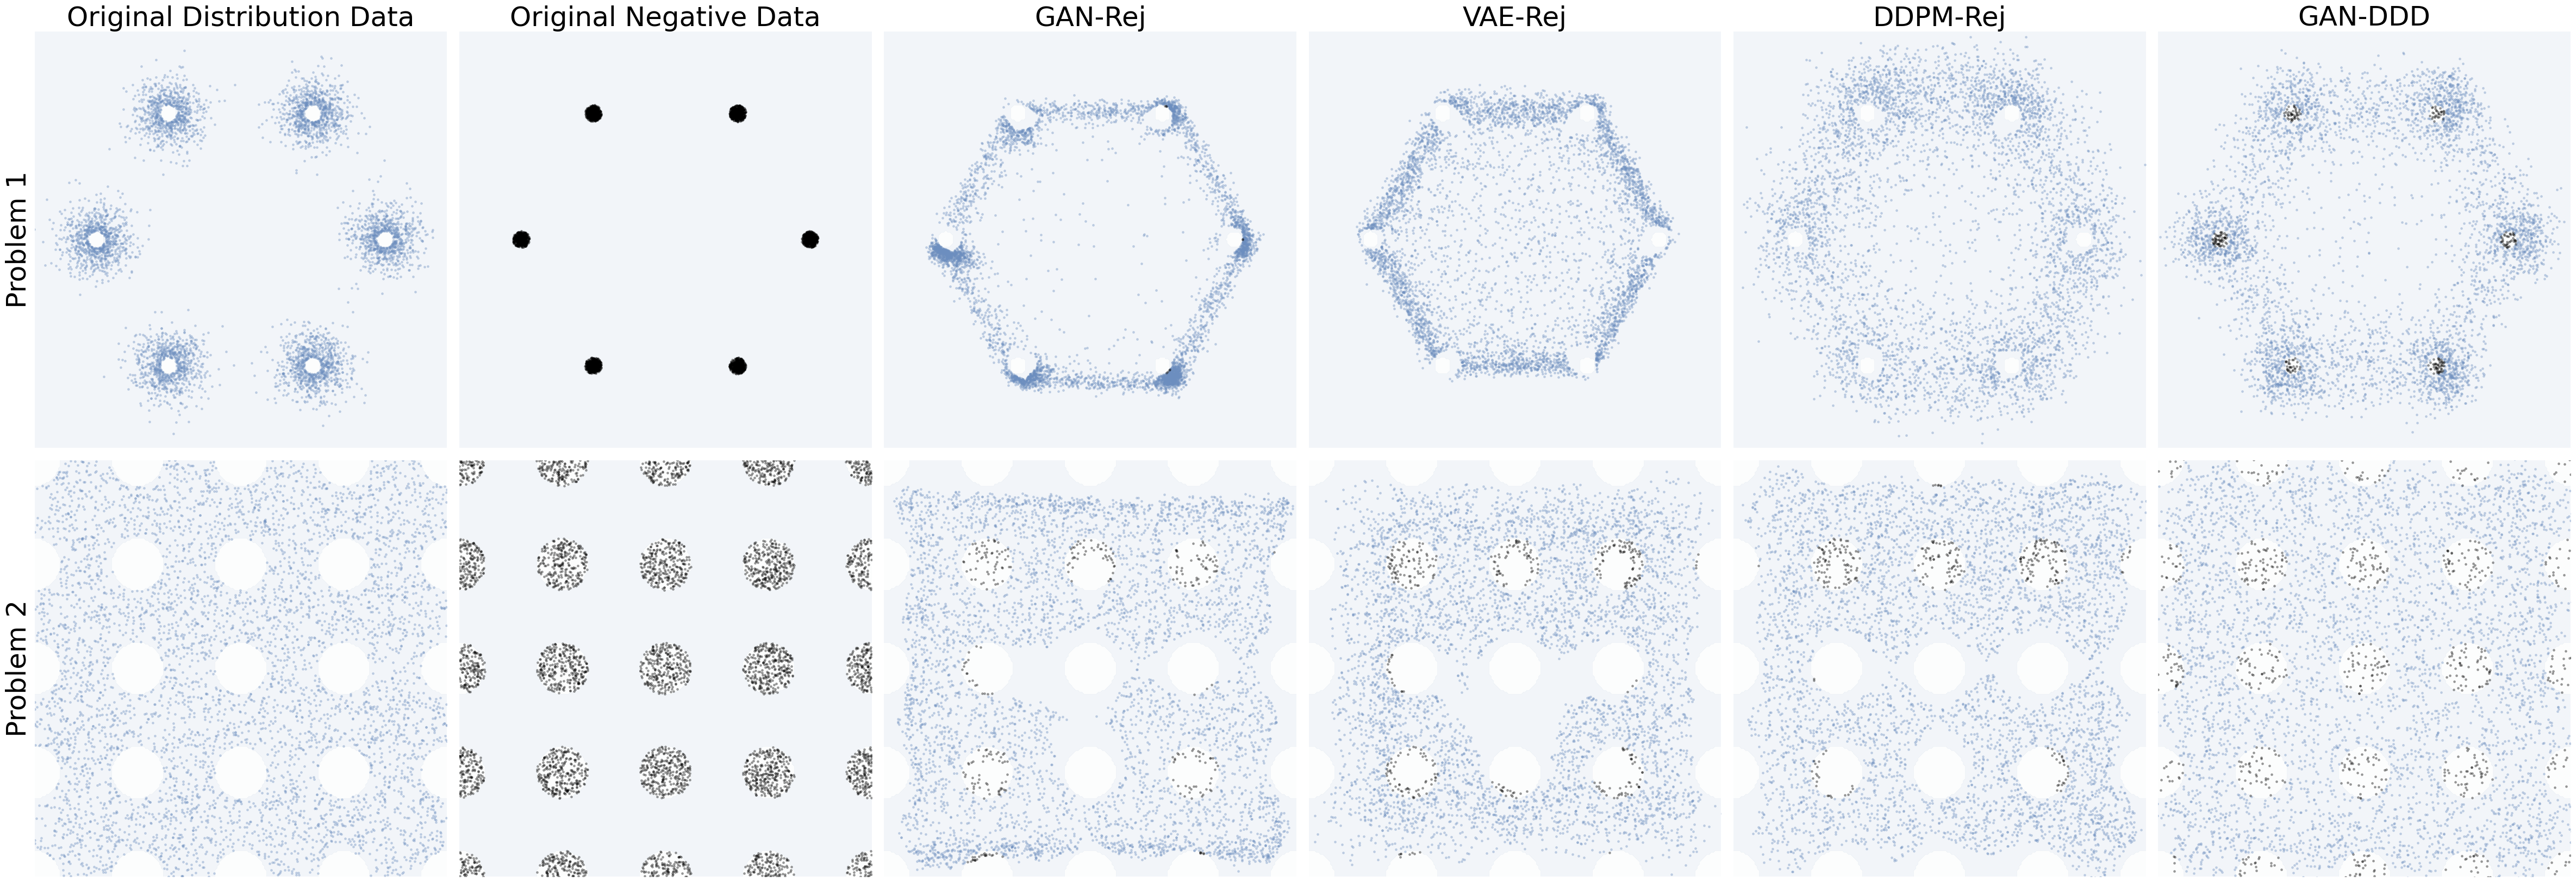

In [4]:
%matplotlib inline
np.random.seed(0) #ensures datasets are the same (models still random)

rangearr = np.array([[-1,1], [-1,1]])

functions=[]

def get_dataset_func(samplingfunction, validityfunction, rangearr):
    def sample(samplingfunction = samplingfunction, validityfunction=validityfunction, rangearr=rangearr):
        distribution, negative = samplingfunction(validityfunction, rangearr)
        positive = distribution #Positive will be ignored for now
        return distribution, negative, positive
    return sample

num_pos = 5000
num_neg = 5000

sampling_func_donuts = load_data.sample_circle_blobs_wrapper(num_pos, num_neg, 6, 0.7, 0.1)
validity_func_donuts = load_data.inv_radial_circles_val_wrapper(0.7, 0.04, 6)
datasetfunction_donuts = get_dataset_func(sampling_func_donuts, validity_func_donuts, rangearr)
functions.append([datasetfunction_donuts, validity_func_donuts, None, rangearr, None, None])

sampling_func_circgrid = load_data.sample_uniform_wrapper(num_pos, num_neg)
validity_func_circgrid = load_data.circles_val_wrapper(0.25, 2)
datasetfunction_circgrid = get_dataset_func(sampling_func_circgrid, validity_func_circgrid, rangearr)
functions.append([datasetfunction_circgrid, validity_func_circgrid, None, rangearr, None, None])

#----------------------------------------------------------------------------------

#Select methods to test
methods=pd.Series()
#[train_step, validity_weight, diversity_weight]

#Classifier-based rejection sampling from appendix
methods["GAN-Rej"] = models_torch.train_wrapper(def_model_params, ["GAN_rej", None, 0])
methods["VAE-Rej"] = models_torch.train_wrapper(def_model_params, ["VAE_rej", None, 0])
methods["DDPM-Rej"] = models_torch.train_wrapper(def_model_params, ["DDPM_rej", None, 0])

#Double discriminator formulation from appendix
methods["GAN-DDD"] = models_torch.train_wrapper(def_model_params, ["GAN_DDD", 0.4, 0.1])

metrics=pd.Series()
metrics["F1"] = ["maximize", evaluation.F_wrapper("x", 1)]
metrics["Validity"] = ["maximize", "Validity"] #Validity is handled specially in utils
metrics["Diversity"] = ["minimize", evaluation.DPP_diversity_wrapper("x", 1000, 10, False)]


timestr = utils.fit_and_generate(functions, methods, numinst, numanim, numgen, scaling, 0, 0, holdout=0)
utils.score(timestr, functions, methods, metrics, numinst, scaling, 0, scorebars, plotscores=True, score_instances=True)
utils.plot_all(timestr, functions, methods, numinst, scaling, 1, 0, 0, 0, "blue", plot_steps=False)